In [196]:
import des_functions as des
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from more_itertools import locate
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)

In [197]:
data_dir = '/home/b7009348/WGL_project/DES-data/'
mcal_file = 'y1_mcal_shapes_matched.fits'
im3_file = 'y1_im3_shapes_matched.fits'

In [198]:
with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    r11 = data['R11']
    r22 = data['R22']
    rsp_ids = data['coadd_objects_id']
    mcal_e1 = data['e1']
    mcal_e2 = data['e2']
    
with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_e1 = data['e1']
    im3_e2 = data['e2']
    im3_ids = data['coadd_objects_id']
    im3_wgt = data['weight']
    m = data['m']
    
rsp_e1 = [r11, im3_e1]
rsp_e2 = [r22, im3_e2]

# Re-weighting im3 ellipticty by response

- r11 ~ r22 so fine to use either for $<R>$ in mcal tang. shear calculation
- However, weighting im3_e2 by r11 results in visibly different distribution to weighting by r22

### Correlation coefficients

In [199]:
hist, r11_bin_edges = np.histogram(r11, bins=10)
r11_bin_edges[-1] = r11_bin_edges[-1] + 0.01 

r11_bin_centers = []
for i in range(len(r11_bin_edges)-1):
    center = (r11_bin_edges[i] + r11_bin_edges[i+1]) / 2
    r11_bin_centers.append(center)
    
hist, r22_bin_edges = np.histogram(r22, bins=10)
r22_bin_edges[-1] = r22_bin_edges[-1] + 0.01 

r22_bin_centers = []
for i in range(len(r22_bin_edges)-1):
    center = (r22_bin_edges[i] + r22_bin_edges[i+1]) / 2
    r22_bin_centers.append(center)

In [200]:
mean_e1 = []
for i in range(len(r11_bin_edges)-1):
    bin_indexes = list(locate(rsp_e1[0], lambda x: x >= r11_bin_edges[i] and x < r11_bin_edges[i+1]))
    e1_bin_values = rsp_e1[1][bin_indexes]
    mean1 = np.mean(e1_bin_values)
    mean_e1.append(mean1)

mean_e2 = []
for i in range(len(r22_bin_edges)-1):
    bin_indexes = list(locate(rsp_e2[0], lambda x: x >= r22_bin_edges[i] and x < r22_bin_edges[i+1]))
    e2_bin_values = rsp_e2[1][bin_indexes]
    mean2 = np.mean(e2_bin_values)
    mean_e2.append(mean2)

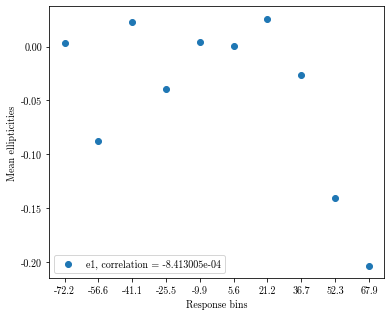

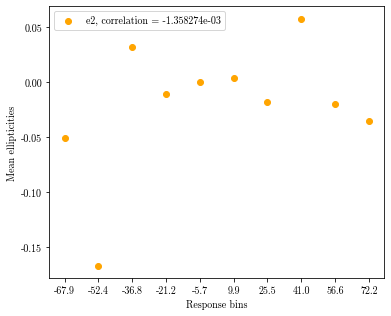

In [204]:
e1_corrcoef = np.corrcoef(x=im3_e1, y=r11)
e2_corrcoef = np.corrcoef(x=im3_e2, y=r22)

plt.figure(figsize=[6,5])
plt.scatter(r11_bin_centers, mean_e1)
plt.xlabel('Response bins')
plt.xticks(r11_bin_centers)
plt.ylabel('Mean ellipticities')
plt.legend(labels=['e1, correlation = %e'%(e1_corrcoef[0,1])])
plt.savefig('e1_response_correlation.png', dpi=300)

plt.figure(figsize=[6,5])
plt.scatter(r22_bin_centers, mean_e2, color='orange')
plt.xlabel('Response bins')
plt.xticks(r22_bin_centers)
plt.ylabel('Mean ellipticities')
plt.legend(labels=['e2, correlation = %e'%(e2_corrcoef[0,1])])
plt.savefig('e2_response_correlation.png', dpi=300)

### Ellipticity distribution plots

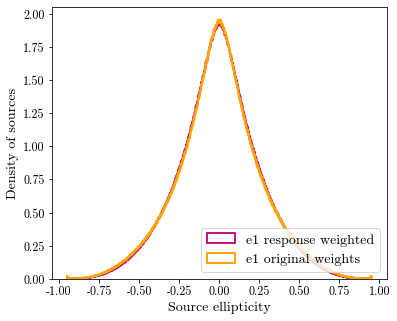

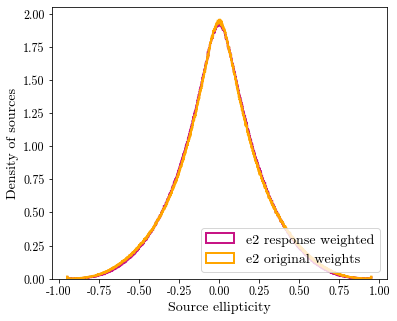

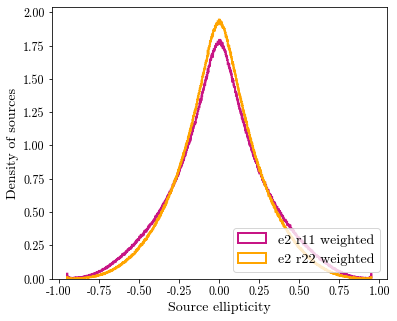

In [223]:
nbins = 1000

plt.figure(figsize=[6,5])
plt.hist(im3_e1, bins=nbins, weights=r11, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(im3_e1, bins=nbins, weights=im3_wgt, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['e1 response weighted', 'e1 original weights'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('e1_ellipticity_dists.png', dpi=300)

plt.figure(figsize=[6,5])
plt.hist(im3_e2, bins=nbins, weights=r22, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(im3_e2, bins=nbins, weights=im3_wgt, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['e2 response weighted', 'e2 original weights'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('e2_ellipticity_dists.png', dpi=300)

plt.figure(figsize=[6,5])
plt.hist(im3_e2, bins=nbins, weights=r11, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(im3_e2, bins=nbins, weights=r22, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['e2 r11 weighted', 'e2 r22 weighted'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('e2_response_dists.png', dpi=300)

### e1 distribution properties

In [208]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [209]:
mean_e1_wgt, std_e1_wgt = weighted_avg_and_std(im3_e1, weights=im3_wgt)
print('Original mean = %e'%mean_e1_wgt, 'Original std = %e'%std_e1_wgt)

mean_e1_rsp, std_e1_rsp = weighted_avg_and_std(im3_e1, weights=r11)
print('Re-weighted mean = %e'%mean_e1_rsp, 'Re-weighted std = %e'%std_e1_rsp)

e1_mean_frac = (mean_e1_wgt - mean_e1_rsp) / mean_e1_wgt
print('Fractional change in mean = %g'%e1_mean_frac)

e1_std_frac = (std_e1_wgt - std_e1_rsp) / std_e1_wgt
print('Fractional change in std = %g'%e1_std_frac)

Original mean = 4.692697e-04 Original std = 2.553134e-01
Re-weighted mean = 3.542325e-04 Re-weighted std = 2.500479e-01
Fractional change in mean = 0.245141
Fractional change in std = 0.0206237


### e2 distribution properties

In [210]:
mean_e2_wgt, std_e2_wgt = weighted_avg_and_std(im3_e2, weights=im3_wgt)
print('Original mean = %e'%mean_e2_wgt, 'Original std = %e'%std_e2_wgt)

mean_e2_rsp, std_e2_rsp = weighted_avg_and_std(im3_e2, weights=r22)
print('Re-weighted mean = %e'%mean_e2_rsp, 'Re-weighted std = %e'%std_e2_rsp)

e2_mean_frac = (mean_e2_wgt - mean_e2_rsp) / mean_e2_wgt
print('Fractional change in mean = %g'%e2_mean_frac)

e2_std_frac = (std_e2_wgt - std_e2_rsp) / std_e2_wgt
print('Fractional change in std = %g'%e2_std_frac)

Original mean = 6.336570e-04 Original std = 2.560108e-01
Re-weighted mean = 4.648207e-04 Re-weighted std = 2.505130e-01
Fractional change in mean = 0.266447
Fractional change in std = 0.0214747


### e2 r11 weighted vs r22 weighted

In [211]:
mean_e2_r11, std_e2_r11 = weighted_avg_and_std(im3_e2, weights=r11)
print('r11 weighted mean = %e'%mean_e2_r11, 'r11 weighted std = %e'%std_e2_r11)

mean_e2_r22, std_e2_r22 = weighted_avg_and_std(im3_e2, weights=r22)
print('r22 weighted mean = %e'%mean_e2_r22, 'r22 weighted std = %e'%std_e2_r22)

e2_mean_frac = (mean_e2_r11 - mean_e2_r22) / mean_e2_r11
print('Fractional change in mean = %g'%e2_mean_frac)

e2_std_frac = (std_e2_r11 - std_e2_r22) / std_e2_r11
print('Fractional change in std = %g'%e2_std_frac)

r11 weighted mean = 6.221747e-04 r11 weighted std = 2.798257e-01
r22 weighted mean = 4.648207e-04 r22 weighted std = 2.505130e-01
Fractional change in mean = 0.25291
Fractional change in std = 0.104753


### e2 r11 weighted vs im3 weighted

In [212]:
mean_e2_wgt, std_e2_wgt = weighted_avg_and_std(im3_e2, weights=im3_wgt)
print('Original mean = %e'%mean_e2_wgt, 'Original std = %e'%std_e2_wgt)

mean_e2_r11, std_e2_r11 = weighted_avg_and_std(im3_e2, weights=r11)
print('Re-weighted mean = %e'%mean_e2_r11, 'Re-weighted std = %e'%std_e2_r11)

e2_mean_frac = (mean_e2_wgt - mean_e2_r11) / mean_e2_wgt
print('Fractional change in mean = %g'%e2_mean_frac)

e2_std_frac = (std_e2_wgt - std_e2_r11) / std_e2_wgt
print('Fractional change in std = %g'%e2_std_frac)

Original mean = 6.336570e-04 Original std = 2.560108e-01
Re-weighted mean = 6.221747e-04 Re-weighted std = 2.798257e-01
Fractional change in mean = 0.0181207
Fractional change in std = -0.0930233


# Reweighting MCAL by multiplicative bias

### Correlation coefficients

In [219]:
mcal_e1_corr = np.corrcoef(x=mcal_e1, y=(1.0+m))
mcal_e2_corr = np.corrcoef(x=mcal_e2, y=(1.0+m))

print(mcal_e1_corr)
print(mcal_e1_corr)

[[ 1.00000000e+00 -2.46993981e-04]
 [-2.46993981e-04  1.00000000e+00]]
[[ 1.00000000e+00 -2.46993981e-04]
 [-2.46993981e-04  1.00000000e+00]]


### Ellipticity distributions

In [ ]:
nbins = 1000

plt.figure(figsize=[6,5])
plt.hist(mcal_e1, bins=nbins, weights=r11, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(mcall_e1, bins=nbins, weights=im3_wgt, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['e1 response weighted', 'e1 original weights'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('e1_ellipticity_dists.png', dpi=300)

plt.figure(figsize=[6,5])
plt.hist(im3_e2, bins=nbins, weights=r22, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(im3_e2, bins=nbins, weights=im3_wgt, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['e2 response weighted', 'e2 original weights'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('e2_ellipticity_dists.png', dpi=300)

plt.figure(figsize=[6,5])
plt.hist(im3_e2, bins=nbins, weights=r11, color='mediumvioletred', density=True, histtype='step', linewidth=2)
plt.hist(im3_e2, bins=nbins, weights=r22, color='orange', density=True, histtype='step', linewidth=2)
plt.legend(['e2 r11 weighted', 'e2 r22 weighted'], loc=4, fontsize=14)
plt.ylabel('Density of sources', fontsize=14)
plt.xlabel('Source ellipticity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('e2_response_dists.png', dpi=300)

### e1 distribution properties

In [217]:
mean_mcal_rsp, std_mcal_rsp = weighted_avg_and_std(mcal_e1, weights=r11)
print('Original mean = %e'%mean_mcal_rsp, 'Original std = %e'%std_mcal_rsp)

mean_mcal_mult, std_mcal_mult = weighted_avg_and_std(mcal_e1, weights=(1.0+m))
print('Re-weighted mean = %e'%mean_mcal_mult, 'Re-weighted std = %e'%std_mcal_mult) 

mean_frac = (mean_mcal_rsp - mean_mcal_mult) / mean_mcal_rsp
print('Fractional change in mean = %g'%mean_frac)

std_frac = (std_mcal_mult - std_mcal_rsp) / std_mcal_mult
print('Fractional change in std = %g'%std_frac)

Original mean = 5.952400e-04 Original std = 1.719502e-01
Re-weighted mean = 4.229274e-04 Re-weighted std = 1.782098e-01
Fractional change in mean = 0.289484
Fractional change in std = 0.0351252


### e2 distribution properties

In [221]:
mean_mcal_rsp, std_mcal_rsp = weighted_avg_and_std(mcal_e2, weights=r22)
print('Original mean = %e'%mean_mcal_rsp, 'Original std = %e'%std_mcal_rsp)

mean_mcal_mult, std_mcal_mult = weighted_avg_and_std(mcal_e2, weights=(1.0+m))
print('Re-weighted mean = %e'%mean_mcal_mult, 'Re-weighted std = %e'%std_mcal_mult) 

mean_frac = (mean_mcal_rsp - mean_mcal_mult) / mean_mcal_rsp
print('Fractional change in mean = %g'%mean_frac)

std_frac = (std_mcal_mult - std_mcal_rsp) / std_mcal_mult
print('Fractional change in std = %g'%std_frac)

Original mean = 6.327820e-04 Original std = 1.729245e-01
Re-weighted mean = 4.014004e-04 Re-weighted std = 1.793362e-01
Fractional change in mean = 0.365658
Fractional change in std = 0.0357521
